# **BERT-large fine-tuning for SST2 dataset.**

In this notebook we will use HuggingFace PyTorch library to quickly fine-tune the model based on BERT-large and to get near state of the art performance on the problem that is included in the GLUE benchmark: SST2.

In [56]:
import os
import time
import torch
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [57]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Let's install the HuggingFace library. 

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use BertForSequenceClassification.

In [58]:
!pip install transformers
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW

Let's load the SST2 dataset.

In [59]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
                 delimiter='\t', header=None, names=['text', 'sentiment'])
print(f"df.shape: {df.shape}")
df.head()

df.shape: (6920, 2)


,text,sentiment
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [60]:
sentences = df["text"].values
labels = df["sentiment"].values

The next step would be loading BERT's tokenizer and formatting input text to the appropriate format for BERT.

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

Oddly, this function can perform truncating for us, but doesn't handle padding. 

In [61]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

input_ids = []
for sentence in sentences:
  encoded_sentence = tokenizer.encode(sentence, add_special_tokens=True)
  input_ids.append(encoded_sentence)

MAX_LEN = max(len(enc_sent) for enc_sent in input_ids)
print(f"Max number of tokens found in sentences: {MAX_LEN}")

input_ids = pad_sequences(input_ids, value=0, padding='post', maxlen=MAX_LEN)

attention_masks = []
for encoded_sentence in input_ids:
  attention_mask = [int(token > 0) for token in encoded_sentence]
  attention_masks.append(attention_mask)

print(f"Original sentence: {sentences[0]}\n")

print(f"Encoded and padded sentence: {input_ids[0]}\n")
print(f"Attention mask for the sentence: {attention_masks[0]}")

Loading BERT tokenizer...
Max number of tokens found in sentences: 67
Original sentence: a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films

Encoded and padded sentence: [  101  1037 18385  1010  6057  1998  2633 18276  2128 16603  1997  5053
  1998  1996  6841  1998  5687  5469  3152   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]

Attention mask for the sentence: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


We will use 90% of the dataset for training and 10% for validation. Also we need to convert our datasets into special data type required for PyTorch.

In [62]:
# Use 90% for training and 10% for validation.
train_val_inputs, test_inputs, train_val_labels, test_labels = train_test_split(input_ids, labels, 
                                                            random_state=2021, test_size=0.1)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_val_inputs, train_val_labels, 
                                                            random_state=2021, test_size=0.1)

# Do the same for the masks.
train_val_masks, test_masks, train_val_labels, _ = train_test_split(attention_masks, labels,
                                             random_state=2021, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(train_val_masks, train_val_labels,
                                             random_state=2021, test_size=0.1)



# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

print(train_inputs.size(), validation_inputs.size(), test_inputs.size())

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

print(train_labels.size(), validation_labels.size(), test_labels.size())

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

print(train_masks.size(), validation_masks.size(), test_masks.size())

torch.Size([5605, 67]) torch.Size([623, 67]) torch.Size([692, 67])
torch.Size([5605]) torch.Size([623]) torch.Size([692])
torch.Size([5605, 67]) torch.Size([623, 67]) torch.Size([692, 67])


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [63]:
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Training the model.

For text classification task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

In [64]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [65]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print(f"name: {p[0]:<55} shape: {str(tuple(p[1].size()))}")

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print(f"name: {p[0]:<55} shape: {str(tuple(p[1].size()))}")

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print(f"name: {p[0]:<55} shape: {str(tuple(p[1].size()))}")

The BERT model has 393 different named parameters.

==== Embedding Layer ====

name: bert.embeddings.word_embeddings.weight                  shape: (30522, 1024)
name: bert.embeddings.position_embeddings.weight              shape: (512, 1024)
name: bert.embeddings.token_type_embeddings.weight            shape: (2, 1024)
name: bert.embeddings.LayerNorm.weight                        shape: (1024,)
name: bert.embeddings.LayerNorm.bias                          shape: (1024,)

==== First Transformer ====

name: bert.encoder.layer.0.attention.self.query.weight        shape: (1024, 1024)
name: bert.encoder.layer.0.attention.self.query.bias          shape: (1024,)
name: bert.encoder.layer.0.attention.self.key.weight          shape: (1024, 1024)
name: bert.encoder.layer.0.attention.self.key.bias            shape: (1024,)
name: bert.encoder.layer.0.attention.self.value.weight        shape: (1024, 1024)
name: bert.encoder.layer.0.attention.self.value.bias          shape: (1024,)
name: bert.encode

# Optimizer and Learning Rate Scheduler

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 2).

In [66]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Training Loop

- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

At first we need to define some useful helper functions.

In [67]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [68]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    # `dropout` and `batchnorm` layers behave differently during training vs. test
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print(f'  Batch {step:>5}  of  {len(train_dataloader):>5}.    Elapsed: {elapsed}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epcoh took: {format_time(time.time() - t0)}")
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print(f"  Accuracy: {eval_accuracy/nb_eval_steps:.2f}")
    print(f"  Validation took: {format_time(time.time() - t0)}")

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    50  of    176.    Elapsed: 0:00:36.
  Batch   100  of    176.    Elapsed: 0:01:13.
  Batch   150  of    176.    Elapsed: 0:01:50.

  Average training loss: 0.31
  Training epcoh took: 0:02:08

Running Validation...
  Accuracy: 0.94
  Validation took: 0:00:04

======== Epoch 2 / 2 ========
Training...
  Batch    50  of    176.    Elapsed: 0:00:36.
  Batch   100  of    176.    Elapsed: 0:01:13.
  Batch   150  of    176.    Elapsed: 0:01:49.

  Average training loss: 0.13
  Training epcoh took: 0:02:07

Running Validation...
  Accuracy: 0.94
  Validation took: 0:00:04

Training complete!


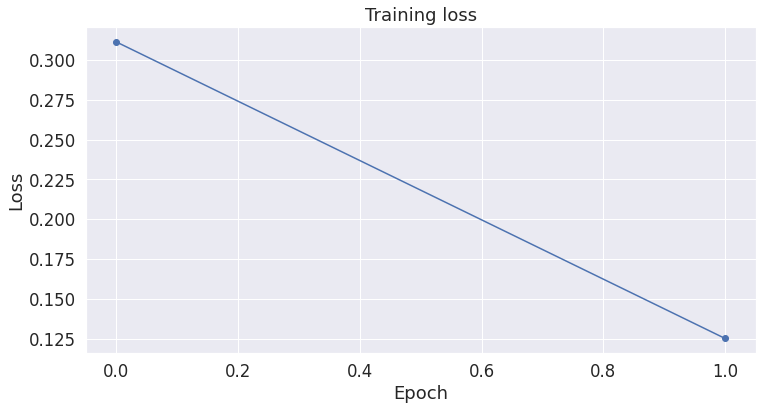

In [69]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Evaluate on the Test Set

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [70]:
# Prediction on test set

print(f'Predicting labels for {len(test_inputs)} test sentences...')

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 692 test sentences...
    DONE.


In [77]:
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)
flat_accuracy(predictions, true_labels)

0.9335260115606936

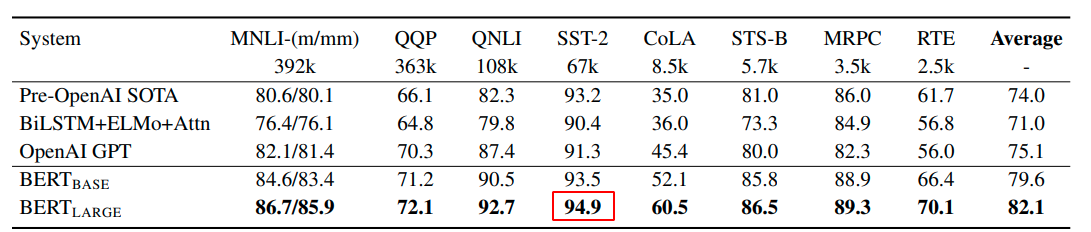

With just 2 epochs we were able to achieve almost state of the art result on sentiment analysis task.

Let's save the model to our google drive.

In [76]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive')

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "/content/drive/MyDrive"

Saving model to ./model_save/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
os.makedirs('test_data', exist_ok=True)
torch.save(test_inputs, './test_data/test_inputs.pt')
torch.save(test_labels, './test_data/test_labels.pt')
torch.save(test_masks, './test_data/test_masks.pt')

!cp -r ./test_data/ "/content/drive/MyDrive"